### Student Name: Martin Power
### Student ID:   9929345
### Model Type:   Regression
### Algorithm: Lasso Regression


# Introduction

This notebook is applying the Lasso Regression algorithm from SciKit-Learn to the UCI Crimes and Communities dataset. The goal is to deliver a model that can take the input attributes from the dataset and use this to predict the percentage of violent crime in the community. The dataset is available at [[7]](http://archive.ics.uci.edu/ml/datasets/communities+and+crime)

During the project, I wanted to apply some of the techniques that were learned during CE4021 and to gain some insight into the real world application of these techniques. Specifically I focused on applying PCA and determining a sensible number of components to retain. I also investigated the impact of using the Tukey Interquartile Range method for outlier removal on the dataset. This was inspired by the talk that April Chen gave in the video section of CE4021 materials and the associated notebook she provied on Github [[1]](https://github.com/aprilypchen/depy2016/blob/master/DePy_Talk.ipynb)


Why did I choose the Lasso model? Well when researching the algorithms I discovered that lasso delivers "sparse" models where most of the coefficients are zero. This is of interest to me as I am interested in how sparsity can be exploited in hardware implementations to deliver more efficient and low power solutions. I was interested to see if using the Lasso model would provide some insight on training a model to be sparse.

Why the UCI Crimes and Community dataset? This dataset was suggested by Cormac in a group meeting and we agreed to pursue 3 dataset initially in order to meet the requirements of this project. Therefore, I used this dataset for my work.

Based on the goals of the project and the specified requirements, the notebook is broken up into the following sections:

* 1 Preparing the Dataset
* 2 Running The Regression
* 3 Applying PCA to the Dataset¶
* 4 Experimenting with Using Lasso on Dataset with Outliers Removed using Tukey IQR Method
* 5 Results
* 6 References
* Appendix 1 : Investigating Impact of n_components on achieved R2S Score
* Appendix 2 : MAE and MSE Scores Obtained During Lasso Regression

Martin Power

In [1]:
# Immport Required Packages and Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline

### Parameters
* SEED : Used as value for functions that take a random seed as an argument. The function of this parameter is to ensure repeatability between runs of the notebook
* TEST_SIZE : Used to determine the split of the dataset into a Test set and a Training Set. Needs to be specified as a float between 0.0 and 1.0
* VERBOSE : Enables higher verbosity for debug etc
* COMPONENT_PCT : Determines the percentage of variance that each component must contribute to be included after applying PCA
* ALPHA : Parameter used by Lasso Regression Algorithm
* NUM_RESULTS : Number of Test Results to be Stored in Result Array
* OUTLIER_LIMIT : If a row contains OUTLIER_LIMIT or more outliers, it is removed from dataset

In [2]:
SEED = 1            # Seed used for randomization and reproducability. Set to None for fully random

TEST_SIZE = 0.3     # Train/Test Set Split

VERBOSE = False     # Notebook Verbosity

COMPONENT_PCT = 0.5 # Half a percent

ALPHA = 0.05        # Alpha used as Lasso parameter

NUM_RESULTS = 8     # Number of Regressions that will be run and need results storage

OUTLIER_LIMIT = 25  # Limit to number of outliers allowed in a row of the dataset

In [3]:
# Numpy Arrays
# Indices:
# [0] = Lasso on Original Dataset
# [1] = LassoCV on Original Dataset
# [2] = Lasso on PCA Dataset
# [3] = LassoCV on PCA Dataset
# [4] = Lasso on Tukey IQR Dataset
# [5] = LassoCV on Tukey IQR Dataset
# [6] = Lasso on Tukey IQR with PCA Dataset
# [7] = LassoCV on Tukey IQR with PCA Dataset

# Use the following arrays to store the results of the regressions:
train_mae = np.zeros(NUM_RESULTS)
train_mse = np.zeros(NUM_RESULTS)
train_r2s = np.zeros(NUM_RESULTS)

test_mae = np.zeros(NUM_RESULTS)
test_mse = np.zeros(NUM_RESULTS)
test_r2s = np.zeros(NUM_RESULTS)

alphas   = np.zeros(NUM_RESULTS)


# 1 Preparing the Dataset

## Loading the dataset

Import the UCI Communities and Crimes dataset using Pandas
Details on the dataset is available at the following [link](http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data)

In [4]:
# Following code is from [2] https://github.com/amclean3695/Communities-and-Crime/blob/master/Communities_and_Crime.ipynb

#Reads in names from textfile and performs regex to extract the attribute names 
textfile = open('communities.names','r')
filetext = textfile.read()
textfile.close()
matches = re.findall(r'-{2}\s(\w+)\:{1}', filetext)
col_names = matches[2:] #corresponds to the 128 attributes

In [5]:
df = pd.read_csv('communities.data', header=None, names=col_names)

#data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'
#df = pd.read_csv(data_url, header=None)
# The above code does not work as PythonAnywhere blocks outgoing connections for free accounts to non-whitelisted sites

print("Original Dataset Shape is ", df.shape)


Original Dataset Shape is  (1994, 128)


## Remove Non-Predictive Attributes

Of the 128 attributes loaded, for this dataset it is stated that:

Attribute Information: (122 predictive, 5 non-predictive, 1 goal) 
* state: US state (by number) - not counted as predictive above, but if considered, should be consided nominal (nominal) 
* county: numeric code for county - not predictive, and many missing values (numeric) 
* community: numeric code for community - not predictive and many missing values (numeric) 
* communityname: community name - not predictive - for information only (string) 
* fold: fold number for non-random 10 fold cross validation, potentially useful for debugging, paired tests - not predictive (numeric) 

Therefore, the first five columns shall be removed from the dataset. This reduces the total number of columns from 128 to 123

In [6]:
df = df.drop(['state', 'county', 'community', 'communityname', 'fold'], axis=1)
print("Dataset Shape with non-predictive attributes removed is ", df.shape)


Dataset Shape with non-predictive attributes removed is  (1994, 123)


## Replace Missing Data
The dataset contains many cells that contain '?'. Attributes with more missing data than valid data will be removed from the dataset. For the remaining attributes with missing data, the missing data will be imputed.

The first step is to replace the cells containing '?' with "NaN" (Not a Number)

In [7]:
# Replace '?' with 'NaN'
df = df.replace('?', np.nan)

# Print the top-25 attributes with missing values. 
# Code reused from April Chen's DePy Talk Notebook in [1]
print("The top 25 attributes with missing data are:")
df.isnull().sum().sort_values(ascending=False).head(25)

The top 25 attributes with missing data are:


LemasSwFTFieldPerPop    1675
PctPolicAsian           1675
PolicBudgPerPop         1675
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicWhite           1675
PctPolicMinor           1675
PolicCars               1675
LemasGangUnitDeploy     1675
LemasPctPolicOnPatr     1675
OfficAssgnDrugUnits     1675
PolicOperBudg           1675
PolicAveOTWorked        1675
NumKindsDrugsSeiz       1675
OtherPerCap                1
PctLess9thGrade            0
PctPopUnderPov             0
dtype: int64

Remove any attributes that have more missing data than valid data

In [8]:
# If a column contains more than 50% of missing data, remove column from dataset
for column in df:
    if(df[column].isnull().sum()>=(df.shape[0]/2)):
        if(VERBOSE==True):
            print("Column ", column, df[column].isnull().sum())
        df = df.drop([column], axis=1)

print("Dataset Shape with attributes with more than 50% missing data removed is ", df.shape)

Dataset Shape with attributes with more than 50% missing data removed is  (1994, 101)


In [9]:
print("The top 5 remaining attributes with missing data are:")
df.isnull().sum().sort_values(ascending=False).head(5)


The top 5 remaining attributes with missing data are:


OtherPerCap       1
PctOccupManu      0
HispPerCap        0
NumUnderPov       0
PctPopUnderPov    0
dtype: int64

There is only one missing value remaining. This single value could be replaced with the median of the column quite simply.

However, for the sake of learning, I want to use the data imputing method outlined in April Chen's DePy_Talk notebook [[1]](https://github.com/aprilypchen/depy2016/blob/master/DePy_Talk.ipynb)

In [10]:
# The missing cell is cell[130]
# The value before imputing is "NaN"
pre_impute = df['OtherPerCap'][130]

# One option to replace the missing data would be to use the median:
miss_median = df['OtherPerCap'].median()

#df['OtherPerCap'][130] = miss_median <-- Use if sklearn required version is unavailable

# Since there is only a single missing value, using an Imputer is overkill.
# However, it is used here for the sake of experimentation

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df) 
df = pd.DataFrame(data=imp.transform(df) , columns=df.columns)

post_impute = df['OtherPerCap'][130]

print("Cell with Missing Data was df['OtherPerCap'][130]")
print("Prior to imputing, the value of this cell was ",pre_impute)
print("Prior to imputing, the median of this attribute was ", miss_median,"This value could have been used instead of using Simple Imputer")
print("Post imputing, the value of this cell is ", post_impute)


Cell with Missing Data was df['OtherPerCap'][130]
Prior to imputing, the value of this cell was  nan
Prior to imputing, the median of this attribute was  0.25 This value could have been used instead of using Simple Imputer
Post imputing, the value of this cell is  0.2847415955845459


## Outlier Detection

Outlier detection uses the Tukey IQR method presented in the DePy Notebook by April Chen[[1]](https://github.com/aprilypchen/depy2016/blob/master/DePy_Talk.ipynb). The find_outliers_tukey() function is reused directly from this notebook.

To allow comparision, the dataset without outliers removed is stored prior to outlier detection and removal. The dataset with outliers removed is also stored. This allows the regression algorithm to be run on both datasets and for the results to be compared

The approach used here is to iterate through all columns and find any values that are considered as outliers using the Tukey IQR method. The indices of the rows in a given column considered as outliers are stored and used to increment a per row outlier count.

At the end of the iteration, any given row that contains >=OUTLIER_LIMIT will be removed from the dataset as it is considered to have a high amount of outlying data

In [11]:
# From DePy_Talk Notebook[1]
# Uses Tukey Inter Quartile Range (IQR) method for Outlier Detection
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices, outlier_values

# Initialize empty array to store the number of outliers detected in each row
num_outliers_per_row = np.zeros(df.shape[0])


# Parse each column and find the indices of the rows with an outlier for that column
for column in df.columns:
    tukey_indices, tukey_values = find_outliers_tukey(df[column])
    #print("Outliers = ",len(tukey_indices), "out of ",len(df[column]), "in",column,"Column")
    # For all the outliers found, using the indices, increase the outlier count for rows wit outliers
    for i in range(len(tukey_indices)):
        num_outliers_per_row[tukey_indices[i]]+=1


The max number of outliers detected in a row is :  34.0
The min number of outliers detected in a row is :  0.0
On average, each row contains  4.799398194583751 columns with data considered as an outlier


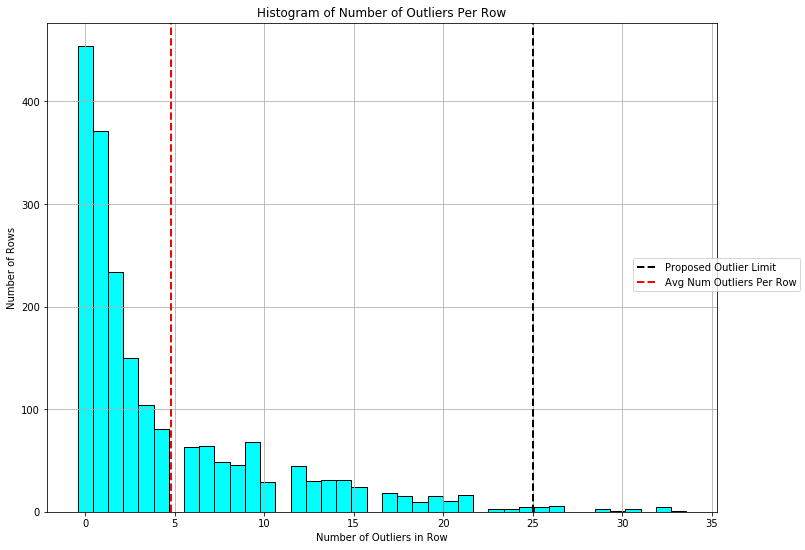

In [12]:
# Parse Array Detailing Number of Outliers per Row
    
print("The max number of outliers detected in a row is : ",num_outliers_per_row.max())
print("The min number of outliers detected in a row is : ",num_outliers_per_row.min())
print("On average, each row contains ",num_outliers_per_row.mean(), "columns with data considered as an outlier")

# Adjust Size of Figures
plt.rcParams["figure.figsize"] = (12,9)

# Display spread of outliers as a histogram
plt.hist(num_outliers_per_row, bins=40, density=False, facecolor='cyan', edgecolor='black', align='left')
plt.xlabel('Number of Outliers in Row')
plt.ylabel('Number of Rows')
plt.title('Histogram of Number of Outliers Per Row')
plt.axvline(OUTLIER_LIMIT, color='k', linestyle='dashed', linewidth=2, label='Proposed Outlier Limit')
plt.axvline(num_outliers_per_row.mean(), color='r', linestyle='dashed', linewidth=2, label='Avg Num Outliers Per Row')
plt.grid(True)
plt.figlegend(loc='right')
plt.show()

In [13]:
# Store off original dataset without outlier detection and removal
dataset = df.values

# Iterate through the per row outlier count and drop any rows that hit the OUTLIER_LIMIT
for i in range(len(num_outliers_per_row)):
    if(num_outliers_per_row[i]>=OUTLIER_LIMIT):
        # Drop row containing the outlier
        df = df.drop([i], axis=0)
        if(VERBOSE==True):
            print("Dropping Row[",i,"]")

print("The limit for retaining a row is",OUTLIER_LIMIT, "outliers. Any rows exceeding this are removed")
print("Dataset Shape After Outlier Removal is ", df.shape)

# Store dataset with outliers removed using Tukey IQR method
tukey_dataset = df.values

The limit for retaining a row is 25 outliers. Any rows exceeding this are removed
Dataset Shape After Outlier Removal is  (1965, 101)


## Split Up Dataset

Use train_test_split() to split the dataset into a Training Set and a Test Set. The split is determined by the parameter TEST_SIZE

In [14]:
# The Dataset shape is (1994, 101). THe first 100 columns are the attributes and the final column is the goal 'ViolentCrimesPerPop'
X = dataset[:, 0:100]
y = dataset[:, 100]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED) 

## Scale the Dataset

Scaling was introduced in Lab 3 of CE4031 Deep Learning module. The scaling performed here follows the method outlined in that lab.

StandardScaler() is used to standardize the features by removing the mean and scaling to unit variance

The fit function is first used on the training data to calculate the mean and the standard deviation. The transform function is then applied independently to the training data and the test data


In [15]:
# Scale the dataset

# Scale the data with respect to the training data set 
scaler = StandardScaler() 
scaler.fit(X_train) 

X_scaled_train = scaler.transform(X_train) 
# Scaling the test set using the transform defined by the train set. 
X_scaled_test = scaler.transform(X_test) 

# 2 Running The Regression

## Lasso Model

Lasso stands for Least Absolute Shrinkage and Selection Operator and is a regression algorithm available in within SciKit Learn. Details are available at <a href="https://en.wikipedia.org/wiki/Lasso_(statistics)">[3]</a>

Lasso is a linear model trained with l1 prior as a regularizer. The regularization is controlled by the constant alpha. Alpha can vary between 0 and 1. A quick survey of reference implementations of Lasso show a value of alpha=0.1 being most commonly used. This is used here initially but subsequently will be improved upon using a grid search with LassoCV


In [16]:
lasso = linear_model.Lasso(alpha=ALPHA)
lasso.fit(X_scaled_train, y_train)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [17]:
#### Function to Print Model Scores
def print_model_scores(y_hat, y, print_scores=True):
    mae = mean_absolute_error(y, y_hat)
    mse = mean_squared_error(y, y_hat)
    r2s = r2_score(y, y_hat)
    if(print_scores==True):
        print("MAE       :", mae)
        print("MSE       :", mse)
        print("R^2 Score :",r2s)
    
    return mae, mse, r2s

In [18]:
# Determine accuracy using the train set
y_hat_train = lasso.predict(X_scaled_train)

print("Lasso Model Train Accuracy")
train_mae[0], train_mse[0], train_r2s[0] = print_model_scores(y_hat_train, y_train)

alphas[0] = ALPHA

Lasso Model Train Accuracy
MAE       : 0.11163927949298785
MSE       : 0.024135166206471208
R^2 Score : 0.5627421370498684


In [19]:
# Determine the accuracy using the test set
y_hat = lasso.predict(X_scaled_test)

print("Lasso Model Test Accuracy")
test_mae[0], test_mse[0], test_r2s[0] = print_model_scores(y_hat, y_test)

Lasso Model Test Accuracy
MAE       : 0.11025089967206587
MSE       : 0.02377442721173159
R^2 Score : 0.5429875563308268


## Gridsearch / Cross Validation with Lasso Model

The initial Lasso model used an alpha value of 0.1. This value was not determined experimentally and instead was used as it is the most common value in reference implementations. This was subsequently changed to 0.05.

SciKit-Learn provides a cross-validation option for using Lasso, LassoCV(), that sets the Lasso alpha value by iterating through a number of values and then selecting the value of alpha that delivers the best model

In [20]:
lasso_cv = LassoCV(alphas = None, cv = 10, max_iter = 100000, random_state=SEED) 
lasso_cv.fit(X_scaled_train, y_train)
print("The value of Alpha determined by cross validation is ", lasso_cv.alpha_)

# Determine accuracy using the train set
y_hat_cv_train = lasso_cv.predict(X_scaled_train)

print("Lasso CV Model Train Accuracy")
train_mae[1], train_mse[1], train_r2s[1] = print_model_scores(y_hat_cv_train, y_train)
alphas[1] = lasso_cv.alpha_

The value of Alpha determined by cross validation is  0.000498969217524633
Lasso CV Model Train Accuracy
MAE       : 0.09118801603926771
MSE       : 0.016454582405940426
R^2 Score : 0.7018916100677516


In [21]:
y_hat_cv = lasso_cv.predict(X_scaled_test)

print("Lasso CV Model Test Accuracy")
test_mae[1], test_mse[1], test_r2s[1]  = print_model_scores(y_hat_cv, y_test)

Lasso CV Model Test Accuracy
MAE       : 0.09352252159300008
MSE       : 0.018937740495832415
R^2 Score : 0.6359624993487838


# 3 Applying PCA to the Dataset

I wanted to use this project as an oppurtunity to apply some of the PCA knowledge acquired during the CE4021 module and to also see some of the real world issues faced when applying PCA.

Specifically, I wanted to find out if there was a deterministic method or some guideline available to help choosing the number of components to retain.

I found a very useful book chapter at [[4]](https://www.researchgate.net/profile/Ehsan_Khedive/post/How_many_components_can_I_retrieve_in_principal_component_analysis/attachment/59d626f2c49f478072e9b1be/AS%3A272185124425729%401441905398541/download/Principal+Component+Analysis+SAS.pdf) . Pages 22-27 give a number of options. A quick summary of these options:
* Eigenvalue-One Criterion - Retain and interpret any component with an eigenvalue greater than 1
* Scree Test - Plot the Eigenvalues associated with each component and look for a "break" between the components with large eigenvalues and small eigenvalues
* Proportion of Variance Accounted For - Retain a component if it accounts for a specified proportion of variance in the data set. For example, you could retain any component that accounts for more than 5% of the total variance. An alternative version of this criterion is to retain enough components to that the cumulative percentage of the variance accounted for is equal to some value. For example, retain enough components to account for 90% of the variance.

The following sections apply PCA to the original Communities and Crime dataset and investigatge the results according to the criterion listed above

## Determining the Appropriate Value for n_components

In [22]:
# Apply an initial run of PCA and use to interrogate the number of components, spread of variance etc

pca = PCA()
pca.fit(X_scaled_train)
X_pca_train = pca.transform(X_scaled_train)
X_pca_test = pca.transform(X_scaled_test)
    

### Eigenvalue-One Criteria Check

In [23]:
# Eigenvalue-One Criteria Check
n_components_gt1 = 0

# Determine the number of components with an Eigenvalue greater than 1.0
for i in range(len(pca.explained_variance_)):
    if(pca.explained_variance_[i]>0.1):
        n_components_gt1+=1
print("Number of PCA components with an Eigenvalue greater than 1.0 is",n_components_gt1)


Number of PCA components with an Eigenvalue greater than 1.0 is 54


### Scree Plot Check

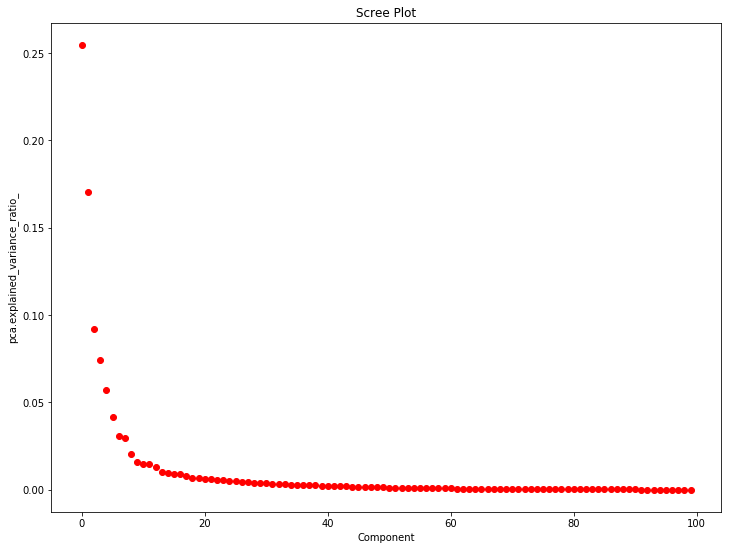

The explained variance ratio shows how much each component contributes to overall variance.
The total overall variance is 1.0
The first component of the PCA analysis contributes over 25% of the total variance
After about 20 components, the amount of variance contributed by each component starts getting to 1% or less


In [24]:
# Plot the Variance Ratio of the Components Determined using PCA. Also known as a scree plot

# Adjust Size of Figures
plt.rcParams["figure.figsize"] = (12,9)

plt.title('Scree Plot')
plt.ylabel('pca.explained_variance_ratio_')
plt.xlabel('Component')
plt.plot(pca.explained_variance_ratio_, 'or')
plt.show()

print("The explained variance ratio shows how much each component contributes to overall variance.")
print("The total overall variance is 1.0")
print("The first component of the PCA analysis contributes over 25% of the total variance")
print("After about 20 components, the amount of variance contributed by each component starts getting to 1% or less")



### Proportion of Variance Accounted For (Cumulative Variance) Check

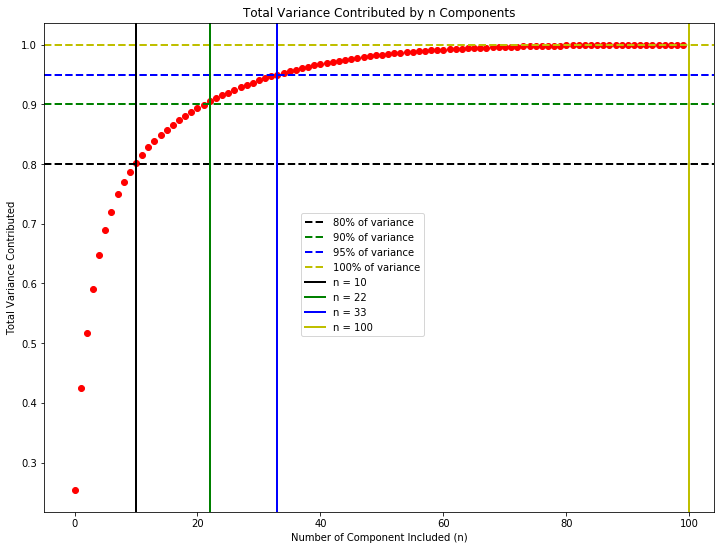

The plot shows the total variance contributed by n components
For example, if all 100 components are included, then 100% of the variance is contributed
However, you can see that if just 10 components are included, 80% of the variance is contributed
Similarly, by including the first 22 components from PCA, 90% of the variance is contributed
To get to 95%, 33 components need to be included. 
The remaining 5% requires an additional 67 components to be included


In [25]:
# Graph detailing how as the number of components that is retained increases, the overall variance approaches 1
# From this graph you can determine how many components are needed to retain 80%, 90%, 95%, etc of the variance

explained_variance_sum = np.zeros(len(pca.explained_variance_ratio_))

ratio_spread = np.zeros(8)
ratios = ['>50% Variance', '>25% Variance', '>10% Variance', '>5% Variance', '>2% Variance', '>1% Variance', '>0.5%Variance', '<0.5% Variance']

for i in range(len(pca.explained_variance_ratio_)):
    if(i==0):
        explained_variance_sum[0] = pca.explained_variance_ratio_[0]
    else:
        explained_variance_sum[i] = explained_variance_sum[i-1] + pca.explained_variance_ratio_[i]
    if(pca.explained_variance_ratio_[i]>=0.5):
        ratio_spread[0]+=1
    if(pca.explained_variance_ratio_[i]>=0.25):
        ratio_spread[1]+=1
    if(pca.explained_variance_ratio_[i]>=0.1):
        ratio_spread[2]+=1
    if(pca.explained_variance_ratio_[i]>=0.05):
        ratio_spread[3]+=1
    if(pca.explained_variance_ratio_[i]>=0.02):
        ratio_spread[4]+=1
    if(pca.explained_variance_ratio_[i]>=0.01):
        ratio_spread[5]+=1
    if(pca.explained_variance_ratio_[i]>=0.005):
        ratio_spread[6]+=1
    if(pca.explained_variance_ratio_[i]<0.005):
        ratio_spread[7]+=1
    if(VERBOSE==True):
        print("i", i, "value", explained_variance_sum[i])
    
plt.title('Total Variance Contributed by n Components')
plt.ylabel('Total Variance Contributed')
plt.xlabel('Number of Component Included (n)')
plt.plot(explained_variance_sum, 'or')
plt.axhline(0.8, color='k', linestyle='dashed', linewidth=2, label='80% of variance')
plt.axhline(0.9, color='g', linestyle='dashed', linewidth=2, label='90% of variance')
plt.axhline(0.95, color='b', linestyle='dashed', linewidth=2, label='95% of variance')
plt.axhline(1.0, color='y', linestyle='dashed', linewidth=2, label='100% of variance')
plt.axvline(10, color='k', linestyle='solid', linewidth=2, label='n = 10')
plt.axvline(22, color='g', linestyle='solid', linewidth=2, label='n = 22')
plt.axvline(33, color='b', linestyle='solid', linewidth=2, label='n = 33')
plt.axvline(100, color='y', linestyle='solid', linewidth=2, label='n = 100')
plt.figlegend(loc='center')
plt.show()

print("The plot shows the total variance contributed by n components")
print("For example, if all 100 components are included, then 100% of the variance is contributed")
print("However, you can see that if just 10 components are included, 80% of the variance is contributed")
print("Similarly, by including the first 22 components from PCA, 90% of the variance is contributed")
print("To get to 95%, 33 components need to be included. \nThe remaining 5% requires an additional 67 components to be included")



### Proportion of Variance Accounted For (% of Total Variance Accounted For) Check

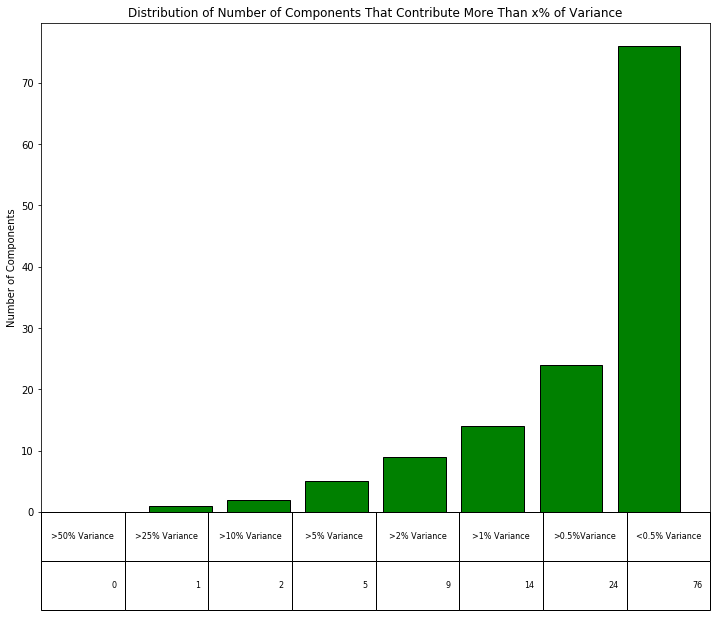

From the chart, it can be seen that one component contributes over 25% of the overall variance
Overall, 24 out of the 110 components each contribute more than 0.5% of the variance.
The remaining 76 each contribute less than half a percent of the variance
Therefore, I am choosing n=24 for applying PCA to the dataset


In [26]:
# The following bar chart shows how many components contribute X% or more of the variance
# e.g. How many components contribute more than 10% of the variance
plt.bar([1,2,3,4,5,6,7,8],ratio_spread,facecolor='green', edgecolor='black')
plt.ylabel('Number of Components')
plt.title('Distribution of Number of Components That Contribute More Than x% of Variance')
# From https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
# Remove ticks and labels from X-axis
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
the_table = plt.table(cellText=(ratio_spread.astype(int).reshape(1,8)),colLabels=ratios,loc='bottom')
# From https://stackoverflow.com/questions/9932072/matplotlib-table-formatting
# Adjust cell height
table_props = the_table.properties()
table_cells = table_props['child_artists']
for cell in table_cells: cell.set_height(0.1)
plt.show()

print("From the chart, it can be seen that one component contributes over 25% of the overall variance")
print("Overall, 24 out of the 110 components each contribute more than 0.5% of the variance.")
print("The remaining 76 each contribute less than half a percent of the variance")
print("Therefore, I am choosing n=24 for applying PCA to the dataset")


## PCA Criteria Check Results and Analysis

* The Eigenvalue One check suggest using n_components=54
* The Scree Plot does not have an obvious break to indicate the split
* The Proportion of Variance Accounted 10 components to get to 80%, 22 components to get to 90% and 33 components to get to 95% of total variance account for. 
* Breaking down the Proportion of Variance by the amount of variance contributed by each vector, it shows that 24 of the vectors contribute more than 0.5% each while the remaining 76% contribute less than half each

Although the Eigenvalue One check suggested using n_components=54, this retained over half of the components and I want to experiment to see what results can be obtained with shrinking the dataset by more than half. Therefore, I am going to retain all components that contribute more than 0.5% of the total variance each. This works out at 24 components which from previous plot indicates that it should account for between 90-95% of the total variance in the dataset

In [27]:
# Determine the number of components that contribute more than COMPONENT_PCT of variance and use this
# value as n_components when applying PCA

n_components_pca = 0

percent_contrib = COMPONENT_PCT

# Determine the number of components that contribute more than 'percent_contrib' of variance and use this for the PCA value
for i in range(len(pca.explained_variance_)):
    if(pca.explained_variance_ratio_[i]>=(percent_contrib/100)):
        n_components_pca+=1
print("Number of PCA components that contribute >=",percent_contrib,"% of variance is ",n_components_pca)

pca_red = PCA(n_components=n_components_pca)
pca_red.fit(X_scaled_train)
X_pca_red_train = pca_red.transform(X_scaled_train)
X_pca_red_test = pca_red.transform(X_scaled_test)
if (VERBOSE==True):
    print(pca_red.explained_variance_)
    print(len(pca_red.explained_variance_))
    print(X_pca_red_train.shape)
    print(X_pca_red_test.shape)
    print(type(pca_red.explained_variance_))
    print(pca_red.explained_variance_.sum())


Number of PCA components that contribute >= 0.5 % of variance is  24


## Running Lasso and LassoCv On PCA-Reduced Dataset

In [28]:
# Lasso with alpha=ALPHA on PCA-reduced Dataset
lasso_pca = linear_model.Lasso(alpha=ALPHA)
lasso_pca.fit(X_pca_red_train, y_train)

y_pca_red_train_hat = lasso_pca.predict(X_pca_red_train)

print("\nLasso Model Train Accuracy on PCA-reduced Data Using Alpha=",ALPHA)
train_mae[2], train_mse[2], train_r2s[2] = print_model_scores(y_pca_red_train_hat, y_train)
alphas[2] = ALPHA

y_pca_red_hat = lasso_pca.predict(X_pca_red_test)

if(VERBOSE==True):
    print(y_pca_red_hat.shape)
    print(y_test.shape)
    print(y_pca_red_hat[0:5])
    print(y_test[0:5])
    print(lasso_pca.score(X_pca_red_test,y_test))

print("\nLasso Model Test Accuracy on PCA-reduced Data Using Alpha=",ALPHA)
test_mae[2], test_mse[2], test_r2s[2]  = print_model_scores(y_pca_red_hat, y_test)


Lasso Model Train Accuracy on PCA-reduced Data Using Alpha= 0.05
MAE       : 0.10559678743397882
MSE       : 0.021825842262882433
R^2 Score : 0.604580260052413

Lasso Model Test Accuracy on PCA-reduced Data Using Alpha= 0.05
MAE       : 0.10365304604755765
MSE       : 0.022059782880632754
R^2 Score : 0.5759479212136577


In [29]:
# LassoCV on PCA-reduced Dataset
lasso_pca_cv = LassoCV(alphas = None, cv = 10, max_iter = 1000, random_state=SEED) 
lasso_pca_cv.fit(X_pca_red_train, y_train)

y_pca_red_train_hat_cv = lasso_pca_cv.predict(X_pca_red_train)

print("\nLasso CV Model Train Accuracy on PCA-reduced Data Using Alpha=",lasso_pca_cv.alpha_)
train_mae[3], train_mse[3], train_r2s[3] = print_model_scores(y_pca_red_train_hat_cv, y_train)
alphas[3] = lasso_pca_cv.alpha_

y_pca_red_hat_cv = lasso_pca_cv.predict(X_pca_red_test)
if(VERBOSE==True):
    print(y_pca_red_hat_cv[0:20])
    print(y_test[0:20])

print("\nLasso CV Model Test Accuracy on PCA-reduced Data Using Alpha=",lasso_pca_cv.alpha_)
test_mae[3], test_mse[3], test_r2s[3]  = print_model_scores(y_pca_red_hat_cv, y_test)


Lasso CV Model Train Accuracy on PCA-reduced Data Using Alpha= 0.001497954939643979
MAE       : 0.09692164248161278
MSE       : 0.018612345693213347
R^2 Score : 0.6627993181119484

Lasso CV Model Test Accuracy on PCA-reduced Data Using Alpha= 0.001497954939643979
MAE       : 0.09525294858602334
MSE       : 0.019513249958301667
R^2 Score : 0.6248995625446525


# 4 Experimenting with  Using Lasso on Dataset with Outliers Removed using Tukey IQR Method

The following section follows the same approach as the previous Lasso runs except this time the source dataset is the dataset with outliers removed using the Tukey IQR method.

I run Lasso and Lasso CV on the Tukey dataset and then I apply PCA to the Tukey dataset and re-run Lasso and Lasso CV.

The goal here is to see the impact of removing the outliers and to see the impact of applying PCA

In [30]:
tukey_X = tukey_dataset[:, 0:100]
tukey_y = tukey_dataset[:, 100]

tukey_X_train, tukey_X_test, tukey_y_train, tukey_y_test = train_test_split(tukey_X, tukey_y, test_size=TEST_SIZE, random_state=SEED) 

# Scale the data with respect to the training data set 
tukey_scaler = StandardScaler() 
tukey_scaler.fit(tukey_X_train) 

tukey_X_scaled_train = tukey_scaler.transform(tukey_X_train) 
# Scaling the test set using the transform defined by the train set. 
tukey_X_scaled_test = tukey_scaler.transform(tukey_X_test) 

tukey_lasso = linear_model.Lasso(alpha=ALPHA)
tukey_lasso.fit(tukey_X_scaled_train, tukey_y_train)

# Determine accuracy using the train set
tukey_y_hat_train = tukey_lasso.predict(tukey_X_scaled_train)

print("\nLasso Model Train Accuracy on Tukey Dataset Using Alpha=",ALPHA)
train_mae[4], train_mse[4], train_r2s[4] = print_model_scores(tukey_y_hat_train, tukey_y_train)
alphas[4] = ALPHA

# Determine the accuracy using the test test
tukey_y_hat = tukey_lasso.predict(tukey_X_scaled_test)

print("\nLasso Model Test Accuracy on Tukey Dataset Using Alpha=",ALPHA)
test_mae[4], test_mse[4], test_r2s[4] = print_model_scores(tukey_y_hat, tukey_y_test)

tukey_lasso_cv = LassoCV(alphas = None, cv = 10, max_iter = 100000, random_state=SEED) 
tukey_lasso_cv.fit(tukey_X_scaled_train, tukey_y_train)


# Determine accuracy using the train set
tukey_y_hat_cv_train = tukey_lasso_cv.predict(tukey_X_scaled_train)

print("\nLasso CV Model Train Accuracy with Tukey Dataset Using Alpha=",tukey_lasso_cv.alpha_)
train_mae[5], train_mse[5], train_r2s[5]  = print_model_scores(tukey_y_hat_cv_train, tukey_y_train)
alphas[5] = tukey_lasso_cv.alpha_

tukey_y_hat_cv = tukey_lasso_cv.predict(tukey_X_scaled_test)

print("\nLasso CV Model Test Accuracy with Tukey Dataset Using Alpha=",tukey_lasso_cv.alpha_)
test_mae[5], test_mse[5], test_r2s[5] = print_model_scores(tukey_y_hat_cv, tukey_y_test)


Lasso Model Train Accuracy on Tukey Dataset Using Alpha= 0.05
MAE       : 0.11230521366338495
MSE       : 0.02486105854901935
R^2 Score : 0.5237754543152446

Lasso Model Test Accuracy on Tukey Dataset Using Alpha= 0.05
MAE       : 0.11080702912180322
MSE       : 0.022872309915470204
R^2 Score : 0.5389739322882035

Lasso CV Model Train Accuracy with Tukey Dataset Using Alpha= 0.00038168568346000944
MAE       : 0.09098461623043984
MSE       : 0.016969650882379526
R^2 Score : 0.6749388500109191

Lasso CV Model Test Accuracy with Tukey Dataset Using Alpha= 0.00038168568346000944
MAE       : 0.09412338824307705
MSE       : 0.01736387504427122
R^2 Score : 0.650004784760071


## Apply PCA Reduction to the Tukey Dataset using same criteria as retaining all components that contribute greater than 0.5% of the total variance

In [31]:
# Apply PCA reduction to the Tukey Dataset
tukey_pca = PCA()
tukey_pca.fit(X_scaled_train)
tukey_X_pca_train = pca.transform(tukey_X_scaled_train)
tukey_X_pca_test = pca.transform(tukey_X_scaled_test)

n_components_pca = 0

percent_contrib = COMPONENT_PCT

# Determine the number of components that contribute more than 'percent_contrib' of variance and use this for the PCA value
for i in range(len(tukey_pca.explained_variance_)):
    if(tukey_pca.explained_variance_ratio_[i]>=(percent_contrib/100)):
        n_components_pca+=1
print("Number of PCA components that contribute >=",percent_contrib,"% of variance is ",n_components_pca)

tukey_pca_red = PCA(n_components=n_components_pca)
tukey_pca_red.fit(tukey_X_scaled_train)
tukey_X_pca_red_train = tukey_pca_red.transform(tukey_X_scaled_train)
tukey_X_pca_red_test = tukey_pca_red.transform(tukey_X_scaled_test)
if (VERBOSE==True):
    print(tukey_pca_red.explained_variance_)
    print(len(tukey_pca_red.explained_variance_))
    print(tukey_X_pca_red_train.shape)
    print(tukey_X_pca_red_test.shape)
    print(type(tukey_pca_red.explained_variance_))
    print(tukey_pca_red.explained_variance_.sum())

Number of PCA components that contribute >= 0.5 % of variance is  24


## Apply Lasso and LassoCV to the Tukey Datset that has been subject to PCA

In [32]:
# Apply Lasso and LassoCV to the PCA-reduced Tukey dataset
tukey_lasso_pca = linear_model.Lasso(alpha=ALPHA)
tukey_lasso_pca.fit(tukey_X_pca_red_train, tukey_y_train)
tukey_y_pca_red_hat_train = tukey_lasso_pca.predict(tukey_X_pca_red_train)

tukey_y_pca_red_hat = tukey_lasso_pca.predict(tukey_X_pca_red_test)

if(VERBOSE==True):
    print(tukey_y_pca_red_hat.shape)
    print(tukey_y_test.shape)
    print(tukey_y_pca_red_hat[0:5])
    print(tukey_y_test[0:5])
    print(tukey_lasso_pca.score(tukey_X_pca_red_test,tukey_y_test))

print("\nLasso Model Train Accuracy on PCA-reduced Tukey Dataset Using Alpha=",ALPHA)
train_mae[6], train_mse[6], train_r2s[6] = print_model_scores(tukey_y_pca_red_hat_train, tukey_y_train)
alphas[6] = ALPHA

print("\nLasso Model Test Accuracy on PCA-reduced Tukey Dataset Using Alpha=",ALPHA)
test_mae[6], test_mse[6], test_r2s[6] = print_model_scores(tukey_y_pca_red_hat, tukey_y_test)

# LassoCV on PCA-reduced Tukey Dataset
tukey_lasso_pca_cv = LassoCV(alphas = None, cv = 10, max_iter = 1000, random_state=SEED) 
tukey_lasso_pca_cv.fit(tukey_X_pca_red_train, tukey_y_train)

tukey_y_pca_red_hat_cv_train = tukey_lasso_pca_cv.predict(tukey_X_pca_red_train)

tukey_y_pca_red_hat_cv = tukey_lasso_pca_cv.predict(tukey_X_pca_red_test)
if(VERBOSE==True):
    print(tukey_y_pca_red_hat_cv[0:20])
    print(tukey_y_test[0:20])

print("\nLasso CV Model Train Accuracy on PCA-reduced Tukey Dataset Using Alpha=",tukey_lasso_pca_cv.alpha_)
train_mae[7], train_mse[7], train_r2s[7] = print_model_scores(tukey_y_pca_red_hat_cv_train, tukey_y_train)
alphas[7] = tukey_lasso_pca_cv.alpha_

print("\nLasso CV Model Score on PCA-reduced Tukey Dataset Using Alpha=",tukey_lasso_pca_cv.alpha_)
test_mae[7], test_mse[7], test_r2s[7] = print_model_scores(tukey_y_pca_red_hat_cv, tukey_y_test)


Lasso Model Train Accuracy on PCA-reduced Tukey Dataset Using Alpha= 0.05
MAE       : 0.10751218145162995
MSE       : 0.023440111930664646
R^2 Score : 0.5509943137388692

Lasso Model Test Accuracy on PCA-reduced Tukey Dataset Using Alpha= 0.05
MAE       : 0.10370032531841641
MSE       : 0.021320514267507976
R^2 Score : 0.5702527252092636

Lasso CV Model Train Accuracy on PCA-reduced Tukey Dataset Using Alpha= 0.0016586970929052377
MAE       : 0.09708818591856107
MSE       : 0.019325659861650454
R^2 Score : 0.629808458496405

Lasso CV Model Score on PCA-reduced Tukey Dataset Using Alpha= 0.0016586970929052377
MAE       : 0.09488664312692038
MSE       : 0.018015906283423522
R^2 Score : 0.6368621070278006


# 5 Results

## Evaluation and Examination of Results

The metrics calculated for the train and test sets for each iteration of the Lasso regression are the Mean Absolute Error (MAE), the Mean Squared Error (MSE) and the R^2 score (R2S).

Details on the MSE and MAE results have been included in an Appendix at the end of this notebook. This section will focus on comparing and contrasting the R2S results obtained for the different iterations of the dataset using both the plain Lasso algorithm and the cross-validation version of the Lasso Algorithm.

The R2S score, also known as the Coefficient of Determination, can take a value between 0 and 1. R2S asseses the goodness of fit in a regression model and the closer the R2S values gets to 1.0, the better the fit.

There are limiations with R2S and this is well documented in [[5]](http://statisticsbyjim.com/regression/interpret-r-squared-regression). However, for the purpose of this project and comparing the results, R2S is going to be used as the main indicator


First of all, add some functions to display and visualise the results from the various configurations of the Lasso Model applied to the Communities and Crimes dataset

In [33]:
# Functions for displaying and visualing Lasso results data

# The code for printing a histogram with multiple data sources in different bars was taken from the following link:
# https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars
# The original code only had 3 sources, it has been updated to handle 4 sources and made more specific to this task
    
def print_lasso_hist(test_result, train_result, ylabel=""):
    N = 4
    ind = np.arange(N)  # the x locations for the groups
    width = 0.22       # the width of the bars

    # Adjust Size of Figures
    plt.rcParams["figure.figsize"] = (12,9)
    fig = plt.figure()
    ax = fig.add_subplot(111)

    yvals = [train_result[0], train_result[2], train_result[4], train_result[6]]
    rects1 = ax.bar(ind, yvals, width, color='r')

    zvals = [test_result[0], test_result[2], test_result[4], test_result[6]]
    rects2 = ax.bar(ind+width, zvals, width, color='g')

    kvals = [train_result[1], train_result[3], train_result[5], train_result[7]]
    rects3 = ax.bar(ind+width*2, kvals, width, color='b')

    jvals = [test_result[1], test_result[3], test_result[5], test_result[7]]
    rects4 = ax.bar(ind+width*3, jvals, width, color='y')

    ax.set_title(ylabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(ind+width)
    ax.set_xticklabels( ('Original', 'PCA', 'Tukey', 'TukeyPCA') )
    ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('Train', 'Test', 'CV Train', 'CV Test') )

    plt.show()
    

def print_lasso_scores(test_result, train_result, alphas):
    print(f"Lasso    on Orig Data      :\tTrain = {train_result[0]:.3f}\tTest = {test_result[0]:.3f}\tAlpha = {alphas[0]:.4f}")
    print(f"Lasso CV on Orig Data      :\tTrain = {train_result[1]:.3f}\tTest = {test_result[1]:.3f}\tAlpha = {alphas[1]:.4f}\n")
    print(f"Lasso    on PCA Data       :\tTrain = {train_result[2]:.3f}\tTest = {test_result[2]:.3f}\tAlpha = {alphas[2]:.4f}")
    print(f"Lasso CV on PCA Data       :\tTrain = {train_result[3]:.3f}\tTest = {test_result[3]:.3f}\tAlpha = {alphas[3]:.4f}\n")
    print(f"Lasso    on Tukey Data     :\tTrain = {train_result[4]:.3f}\tTest = {test_result[4]:.3f}\tAlpha = {alphas[4]:.4f}")
    print(f"Lasso CV on Tukey Data     :\tTrain = {train_result[5]:.3f}\tTest = {test_result[5]:.3f}\tAlpha = {alphas[5]:.4f}\n")
    print(f"Lasso    on Tukey PCA Data :\tTrain = {train_result[6]:.3f}\tTest = {test_result[6]:.3f}\tAlpha = {alphas[6]:.4f}")
    print(f"Lasso CV on Tukey PCA Data :\tTrain = {train_result[7]:.3f}\tTest = {test_result[7]:.3f}\tAlpha = {alphas[7]:.4f}\n")


## R2S Scores for Lasso Model on "Communities and Crime Dataset"

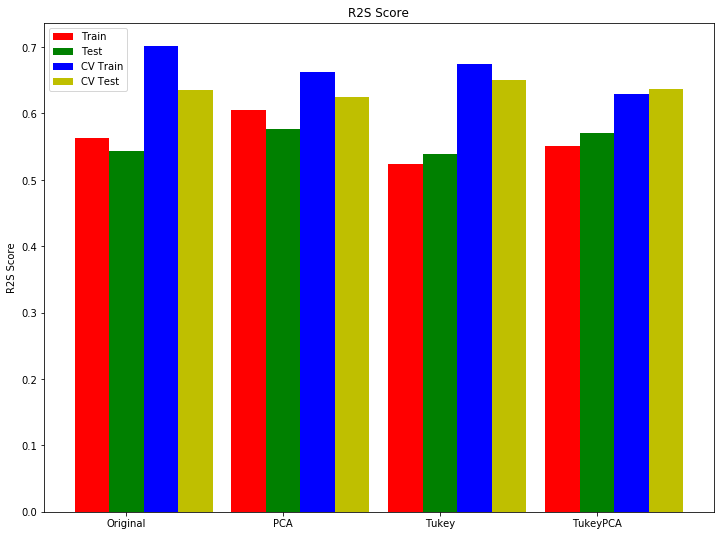


		 -- R2S Scores --

Lasso    on Orig Data      :	Train = 0.563	Test = 0.543	Alpha = 0.0500
Lasso CV on Orig Data      :	Train = 0.702	Test = 0.636	Alpha = 0.0005

Lasso    on PCA Data       :	Train = 0.605	Test = 0.576	Alpha = 0.0500
Lasso CV on PCA Data       :	Train = 0.663	Test = 0.625	Alpha = 0.0015

Lasso    on Tukey Data     :	Train = 0.524	Test = 0.539	Alpha = 0.0500
Lasso CV on Tukey Data     :	Train = 0.675	Test = 0.650	Alpha = 0.0004

Lasso    on Tukey PCA Data :	Train = 0.551	Test = 0.570	Alpha = 0.0500
Lasso CV on Tukey PCA Data :	Train = 0.630	Test = 0.637	Alpha = 0.0017



In [34]:
### R2S Scores for Lasso Model

print_lasso_hist(test_r2s, train_r2s, "R2S Score")
print("\n\t\t -- R2S Scores --\n")
print_lasso_scores(test_r2s, train_r2s, alphas)

## R2S Results Analysis



The above bar chart plots the train and test R2S scores for the four variants of the dataset (Original, Original with PCA reduction, Tukey Dataset with Outliers Removed and Tukey Dataset with PCA reduction) for both the plain Lasso algorithm and the LassoCV alrogithm that uses cross validation to find the optimal value of alpha.

For the original dataset, Lasso gives a test accuracy of 0.543 with a hard coded value of alpha=0.5. Running the same dataset through the cross validation version of Lasso returns a test accuracy of 0.636. The cross validation adjusted the value of alpha from 0.5 to 0.005 (several orders of magnitude!) and this accounted for the improvment in the value.

Applying PCA to this dataset with n_components=24 manages to improve the test accuracy for alpha=0.5 from 0.543 to 0.576. However, for the LassoCV algorithm, the test accuracy drops slightly from 0.636 to 0.631. This time the CV model converged on a value of alpha=0.0013. This suggests that tuning alpha provides more return than reducing the dataset.

In all cases using the originial dataset, the training accuracy was slightly higher than test accuracy. There were no big gaps in training versus test performance. This suggests that the model is generalizing reasonably well from the train set to the test set.

When moving on to the dataset that was reduced using Tukey analysis, the results obtained differ from those obtained with the original dataset. The Tukey dataset removed any rows that contained 25 or more attributes that were considered as an outlier using the Tukey IQR method. This reduced the number of rows in the dataset from 1994 to 1965.

Running Lasso with alpha=0.5 on this dataset performed slightly worse than running on the original dataset. The test accuracy was also slightly higher than the training accuracy in this case. Similarly for the PCA-reduced version of the Tukey dataset, running with alpha=0.5 performed slightly worse than the original dataset.

However, when running LassoCV, better or equivalent results were obtained using the Tukey dataset. When running Lasso with alpha=0.5 on the Tukey, the test accuracy obtained was similar to running on the original dataset and was not great - this suggests that the selection of alpha=0.5 is more significant than cleaning up the dataset in this instance.

Running LassoCV on the Tukey dataset converged on an alpha=0.0004 and delivered a R2S value of 0.65. This was the highest test accuracy obtained and slightly bettered the 0.636 obtained when running LassoCV on the original dataset. The LassoCV run on the Tukey dataset with PCA reduction applied performed a littler worse than LassoCV on the non-PCA reduced version of the Tukey dataset and close to the value obtained when LassoCV was run on the PCA-reduced version of the original datset.

The first conclusion is that when using the Lasso algorithm tuning alpha using Cross Validation is much more important than reducing the dimensionality using PCA.

The second conclusion is that once alpha was tuned using CV, the PCA reduced datasets performed slightly worse than the non-PCA reduced datasets. This suggests that the number of components may need to be increased from 24. This is further expanded upon in Appendix 1.

The final conclusion is that applying outlier detection can improve performance. However, for this project the value of the outlier limit was experimented with a 25 was found to be the sweet spot. Other values performed worse than this value. The outlier removal in this project was performed in an almost blind fashion as the Tukey IQR criteria were applied without rigourously plotting or interogating the data. For a real world application, this sort of analysis would have to be performed to quantify if the outlier removal is really removing valid outliers or not.

Finally, is the value of R2S=0.65 obtained using LassoCV with alpha=0.0004 on the Tukey dataset a reasonable value that could be obtained using the Lasso algorithm? Surveying on GitHub, the best reference I could find was  [[6]](https://github.com/vbordalo/Communities-Crime/blob/master/Crime_v1.ipynb) . In this notebook, a RANSAC regressor with outlier removal was used and with a similar train/test split as in this notebook, an R2S value of 0.6544. While obviously not an exhaustive trawl, this suggests the results obtained are similar.


#  6 References

* [1] [Depy 2016 Talk: Pre-Modeling: Data Preprocessing and Feature Exploration in Python Notebook](https://github.com/aprilypchen/depy2016/blob/master/DePy_Talk.ipynb)
* [2] [amclean3695's Communities-and-Crime Notebook](https://github.com/amclean3695/Communities-and-Crime/blob/master/Communities_and_Crime.ipynb)
* [3] <a href="https://en.wikipedia.org/wiki/Lasso_(statistics)">LASSO Algorithm Wikipedia Entry</a>
* [4] [Principle Component Analysis SAS Book Chapter](https://www.researchgate.net/profile/Ehsan_Khedive/post/How_many_components_can_I_retrieve_in_principal_component_analysis/attachment/59d626f2c49f478072e9b1be/AS%3A272185124425729%401441905398541/download/Principal+Component+Analysis+SAS.pdf)
* [5] [How To Interpret R-squared in Regression Analysis](http://statisticsbyjim.com/regression/interpret-r-squared-regression)
* [6] [vbordalo's Crime_v1 Notebook](https://github.com/vbordalo/Communities-Crime/blob/master/Crime_v1.ipynb)
* [7] [Crimes and Communities Dataset](http://archive.ics.uci.edu/ml/datasets/communities+and+crime)

# Appendix 1 : Investigating Impact of n_components on achieved R2S Score

The previous results used n_components=24 for the PCA-reduced datasets. This number was determined by including any component that contributed more than 0.5% of the total variance. If the Eigenvalue-One criterion was used and every Eigenvalue with a value greater than 1.0  was retained then a value of n_components=54 would have been used.

In this section, all possible value of n_components is looped through and the R2S scores are plotted. This will show the delta between the selected value of n_components and the available value of n_components.

Credit to Cormac Lavery for this idea and pushing the initial code for this section to this notebook.

In [35]:
# Run PCA with maximum number of components. This will 
# be used as the basis for sweeping through all values of n_components
pca_for_count_of_components = PCA()
pca_for_count_of_components.fit(X_scaled_train)
X_PCA_train = pca_for_count_of_components.transform(X_scaled_train)
X_PCA_test  = pca_for_count_of_components.transform(X_scaled_test)
total_components = len(pca.explained_variance_)

# Array to store Results of Sweeping Number of Components
pca_results_n_components_lasso = []
pca_results_n_components_lasso_cv = []

# Use function to run Lasso and Lasso CV.
# Ensures no issues with retraining the same model between iterations
def run_lasso_and_lasso_cv(X_train, X_test, y_train):
    lasso_x = linear_model.Lasso(alpha=ALPHA)
    lasso_x.fit(X_train, y_train)
    y_hat = lasso_x.predict(X_test)
    
    lasso_x_cv = LassoCV(alphas = None, cv = 10, max_iter = 1000, random_state=SEED) 
    lasso_x_cv.fit(X_train, y_train)
    y_hat_cv = lasso_x_cv.predict(X_test)
    
    return y_hat, y_hat_cv

# Run Lasso and LassoCV for all allowed number of PCA components
for i in range(1,total_components):
    # Use i number of components
    X_pca_n_train = X_PCA_train[:,:i]
    X_pca_n_test  = X_PCA_test[:,:i]

    y_n_hat, y_n_hat_cv = run_lasso_and_lasso_cv(X_pca_n_train, X_pca_n_test, y_train)

    mae, mse, r2s = print_model_scores(y_n_hat, y_test, print_scores=False)
    pca_results_n_components_lasso.append((mae,mse,r2s))
    
    mae_cv, mse_cv, r2s_cv = print_model_scores(y_n_hat_cv, y_test, print_scores=False)
    pca_results_n_components_lasso_cv.append((mae_cv,mse_cv,r2s_cv))
    
    
maes, mses, r2ss = zip(*pca_results_n_components_lasso)
maes_cv, mses_cv, r2ss_cv = zip(*pca_results_n_components_lasso_cv)

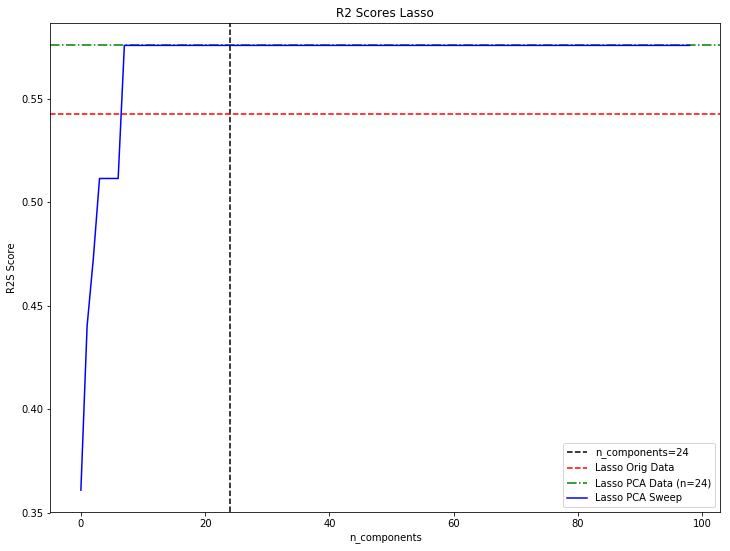

Lasso Regression on Original Data              :	Test = 0.5430
Lasso Regression on PCA Data (n_components=24) :	Test = 0.5759
Lasso Regression on PCA Sweep                  :	Test = 0.5759


In [36]:
# Extract Results from Original Runs for Purpose of Plotting
r2s_original = test_r2s[0]
r2s_cv       = test_r2s[1]
r2s_pca      = test_r2s[2]
r2s_pca_cv   = test_r2s[3]

mae_original = test_mae[0]
mae_cv       = test_mae[1]
mae_pca      = test_mae[2]
mae_pca_cv   = test_mae[3]

mse_original = test_mse[0]
mse_cv       = test_mse[1]
mse_pca      = test_mse[2]
mse_pca_cv   = test_mse[3]


plt.title("R2 Scores Lasso")
plt.xlabel("n_components")
plt.ylabel("R2S Score")
plt.axvline(x=24, color='k', linestyle='dashed', label="n_components=24")
plt.axhline(y=r2s_original, color='r', linestyle='dashed', label="Lasso Orig Data")
plt.axhline(y=r2s_pca, color='g', linestyle='-.', label="Lasso PCA Data (n=24)")
plt.plot(r2ss, color='b', label="Lasso PCA Sweep")
plt.legend(loc='best')
plt.show()

print(f"Lasso Regression on Original Data              :\tTest = {r2s_original:.4f}")
print(f"Lasso Regression on PCA Data (n_components=24) :\tTest = {r2s_pca:.4f}")
print(f"Lasso Regression on PCA Sweep                  :\tTest = {r2ss[-1]:.4f}")


### Impact of n_components on Lasso Regression (Non-CV Version)

After between 5 and 10 components, the achieved R2S score saturates at 0.5759. This is because the hard coded value of alpha is preventing the algorithm for better fitting the data.

In this instance, using a value of n_components greater than 24 would not have improved the results. 

Next, we look at the same plot but for the cross validation version of the algorithm

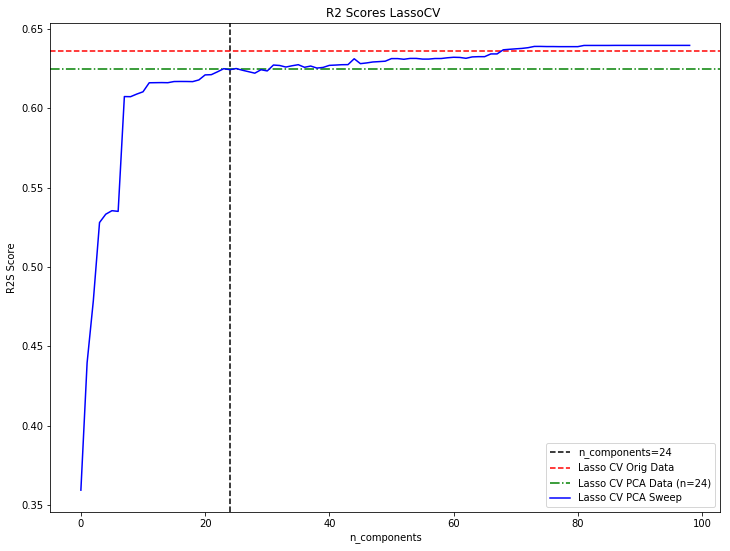

Lasso CV Regression on Original Data              :	Test = 0.6360
Lasso CV Regression on PCA Data (n_components=24) :	Test = 0.6249
Lasso CV Regression on PCA Sweep                  :	Test = 0.6397


In [37]:
plt.title("R2 Scores LassoCV ")
plt.xlabel("n_components")
plt.ylabel("R2S Score")
plt.axvline(x=24, color='k', linestyle='dashed', label="n_components=24")
plt.axhline(y=r2s_cv, color='r', linestyle='dashed', label="Lasso CV Orig Data")
plt.axhline(y=r2s_pca_cv, color='g', linestyle='-.', label="Lasso CV PCA Data (n=24)")
plt.plot(r2ss_cv, color='b', label="Lasso CV PCA Sweep")
plt.legend(loc='best')
plt.show()

print(f"Lasso CV Regression on Original Data              :\tTest = {r2s_cv:.4f}")
print(f"Lasso CV Regression on PCA Data (n_components=24) :\tTest = {r2s_pca_cv:.4f}")
print(f"Lasso CV Regression on PCA Sweep                  :\tTest = {r2ss_cv[-1]:.4f}")

### Impact of n_components on Lasso CV Regression 

Using n_components = 24, achieved an R2S score of 0.6314 on the PCA data. This was slightly less than the score (0.6360) achieved using the non-PCA reduced data with all attributes included.

By increasing n, we can see from the graph the performance of the PCA iteration version exceeds the version with n_components=24 when the number of components retained approaches 60. This suggests that the Eigenvalue-One criterion which would have kept 54 components would have delivered close to or slightly better performance than using n_components = 24

Finally, when approximately 70 components are retained, the PCA regression performance exceeds the R2S score achieved on the original data set. This suggests that using PCA on this dataset can indeed deliver better, or at least similar, performance to using a dataset that retains all the oringal attributes

# Appendix 2 : MAE and MSE Scores Obtained During Lasso Regression

The results section focused on the R2S score achieved for the various datasets and values of alpha. The MSE and MAE values were not discussed. For the sake of completeness, similar bar charts to the R2S bar charts are included for MSE and MAE. They are provided for reference only.

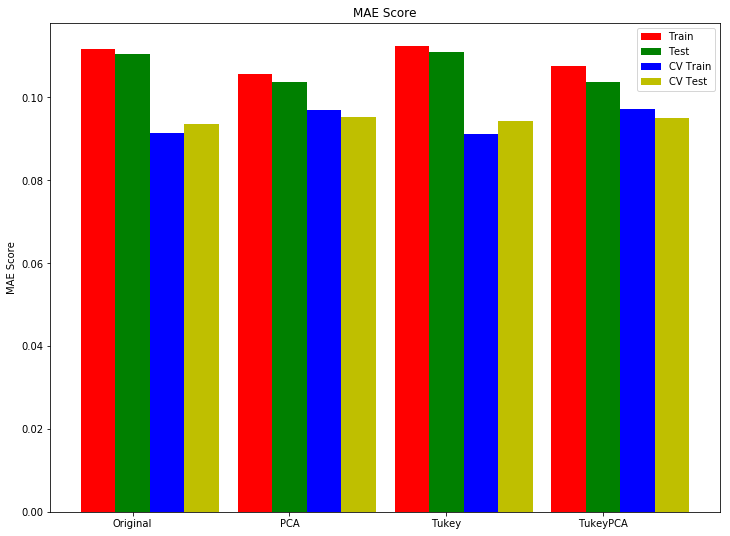

MAE Scores
Lasso    on Orig Data      :	Train = 0.112	Test = 0.110	Alpha = 0.0500
Lasso CV on Orig Data      :	Train = 0.091	Test = 0.094	Alpha = 0.0005

Lasso    on PCA Data       :	Train = 0.106	Test = 0.104	Alpha = 0.0500
Lasso CV on PCA Data       :	Train = 0.097	Test = 0.095	Alpha = 0.0015

Lasso    on Tukey Data     :	Train = 0.112	Test = 0.111	Alpha = 0.0500
Lasso CV on Tukey Data     :	Train = 0.091	Test = 0.094	Alpha = 0.0004

Lasso    on Tukey PCA Data :	Train = 0.108	Test = 0.104	Alpha = 0.0500
Lasso CV on Tukey PCA Data :	Train = 0.097	Test = 0.095	Alpha = 0.0017



In [38]:
print_lasso_hist(test_mae, train_mae, "MAE Score")
print("MAE Scores")
print_lasso_scores(test_mae, train_mae, alphas)

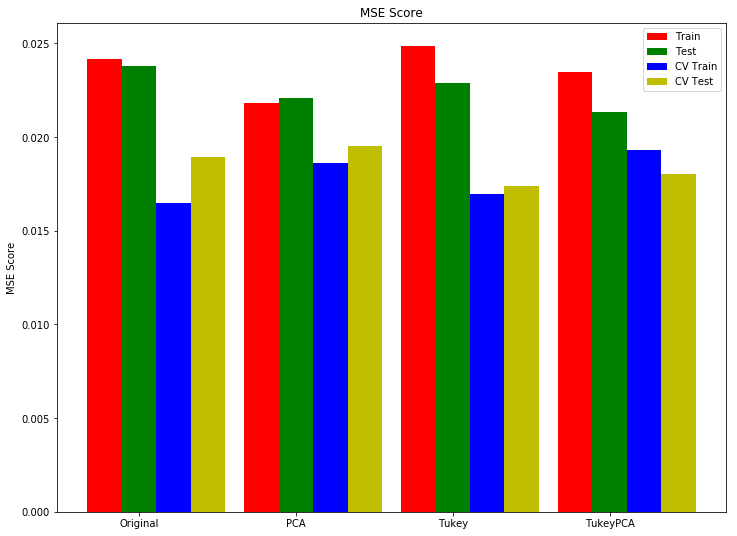

MSE Scores
Lasso    on Orig Data      :	Train = 0.024	Test = 0.024	Alpha = 0.0500
Lasso CV on Orig Data      :	Train = 0.016	Test = 0.019	Alpha = 0.0005

Lasso    on PCA Data       :	Train = 0.022	Test = 0.022	Alpha = 0.0500
Lasso CV on PCA Data       :	Train = 0.019	Test = 0.020	Alpha = 0.0015

Lasso    on Tukey Data     :	Train = 0.025	Test = 0.023	Alpha = 0.0500
Lasso CV on Tukey Data     :	Train = 0.017	Test = 0.017	Alpha = 0.0004

Lasso    on Tukey PCA Data :	Train = 0.023	Test = 0.021	Alpha = 0.0500
Lasso CV on Tukey PCA Data :	Train = 0.019	Test = 0.018	Alpha = 0.0017



In [39]:
print_lasso_hist(test_mse, train_mse, "MSE Score")
print("MSE Scores")
print_lasso_scores(test_mse, train_mse, alphas)